# DF6 individual global figures for the multipanel Figure 1 of Chapter 12

## Produces the figures for:
- 20412060 ssp585 - historical (mid-21st century)
- 20812100 ssp585 - historical (late-21st century)
- 20812100 ssp126 - historical (late-21st century)
- the colorbar

In [1]:
# -- Preparing the files

# -- Select the periods by scenario
# -- Compute annual sums
# -- Split the annual files
# -- Using CliMAF:
# --   - compute the individual differences
# --   - compute the ensemble statistics
# --   - start the plot of the ensemble median
# --   - code model agreement

In [2]:
import os, glob
import xarray as xr
from IPython.display import Image
from PIL import Image as PILImage

# Preprocessing to use the files with CliMAF

## The input files are provided by Atlas (Maialen Iturbide)

In [41]:
# -- Function to split a multi-member file in individual files
# -- Uses Xarray
def split_ensemble_file(ensemble_file, output_pattern, variable='spell'):
    if not os.path.isdir(os.path.dirname(output_pattern)):
        os.makedirs(os.path.dirname(output_pattern))
    import xarray as xr
    dat = xr.open_dataset(ensemble_file, decode_times=False)[variable]
    i = 0
    for member in dat.time:
        print i
        outfilename = output_pattern+'model'+str(i)+'.nc'
        if not os.path.isfile(outfilename):
            print 'Save '+outfilename
            member_dat = dat[i,:,:]
            wfile = outfilename.replace('.nc','tmp.nc')    
            member_dat.to_netcdf(wfile)
            cmd = 'cdo -b 32 setmissval,1e+20 -copy '+wfile+' '+outfilename+' ; ncrename -v spell,DF6 '+outfilename+' ; rm -f '+wfile
            print cmd
            cmd2 = 'ncatted -O -a coordinates,DF6,o,c,"lat lon" -a units,DF6,o,c,"Droughts" -a long_name,DF6,o,c,"Number of droughts per decade (DF6 index)" '+outfilename
            print cmd2
            os.system(cmd)
            os.system(cmd2)
        else:
            print outfilename+' already exists'
        i = i + 1

In [3]:
variable='DF6'
CMIP = 'CMIP6'

In [ ]:
# -- Compute the annual sums
exp_list = [
    dict(experiment='ssp585',
         clim_period = 'hist'),
    dict(experiment='ssp585',
         clim_period = 'farfut'),
    dict(experiment='ssp585',
         clim_period='midfut'),
    dict(experiment='ssp126',
         clim_period = 'farfut'),
    dict(experiment='ssp126',
         clim_period = 'hist'),
    dict(experiment='ssp585',
         clim_period = 'farch'),
    dict(experiment='ssp585',
         clim_period='midch'),
    dict(experiment='ssp126',
         clim_period = 'farch'),
]

for exp_dict in exp_list:
    clim_period = exp_dict['clim_period']
    experiment = exp_dict['experiment']
    wfile = '/data/jservon/IPCC/DF/CMIP6/CMIP6_'+experiment+'-DF6-'+clim_period+'.nc'
    output_pattern = '/data/jservon/IPCC/DF/individual_models/CMIP6/CMIP6_'+experiment+'_DF6_'+clim_period+'_'
    split_ensemble_file(wfile, output_pattern)

# Start analyses to do the plots

### Import the CliMAF library to do the pretreatments (https://climaf.readthedocs.io/en/master/)

In [4]:
from climaf.api import *

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


### Declare the access to the archive

In [5]:
variable='DF6'
CMIP = 'CMIP6'
pattern = '/data/jservon/IPCC/DF/individual_models/'+CMIP+'/'+CMIP+'_${experiment}_${variable}_${clim_period}_${member}.nc'
cproject('DF6_individual_models_cmip6_ch12','experiment','clim_period','member',('variable',variable),('period','fx'), ensemble=['member'], separator='%')
dataloc(project='DF6_individual_models_cmip6_ch12', url=pattern)    

<climaf.dataloc.dataloc instance at 0x2ad2bd208758>

## Work on the individual models:
- create scenario and baseline ensembles => select common models
- compute annual sums
- compute climatologies
- compute differences

In [6]:

exp_list = [
    dict(experiment='ssp585',
         clim_period = 'farch'),
    dict(experiment='ssp585',
         clim_period='midch'),
    dict(experiment='ssp126',
         clim_period = 'farch'),
]


# -- Loop on the scenarios
ens_diff = dict()
for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    clim_period = exp['clim_period']
       
    # -- Changes = Scenario minus baselines
    req_exp = ds(project='DF6_individual_models_cmip6_ch12',
                 experiment = experiment,
                 clim_period = clim_period,
                 member = '*'
                )
    diff_exp_baseline = req_exp.explore('ensemble')
    ens_diff[experiment+'_'+clim_period] = diff_exp_baseline

In [7]:
pp_colorbar = dict(proj   = 'Robinson',
                   colors = '-3.5 -2.5 -2 -1.5 -1 -0.25 0.25 1 1.5 2 2.5 3.5',
                   color  = 'dfpalette',
                   mpCenterLonF = 0,
                   focus = 'land',
                   tiMainFontHeightF=0.03,
                   gsnStringFontHeightF=0.02,
                   gsnRightString='', gsnLeftString=''
                  )

In [8]:
pp = pp_colorbar.copy()
pp.update(
    dict(options='gsnAddCyclic=True|lbLabelBarOn=False|lbBoxEndCapStyle=TriangleBothEnds|mpGridAndLimbOn=True|mpGridLineColor=-1')
)         

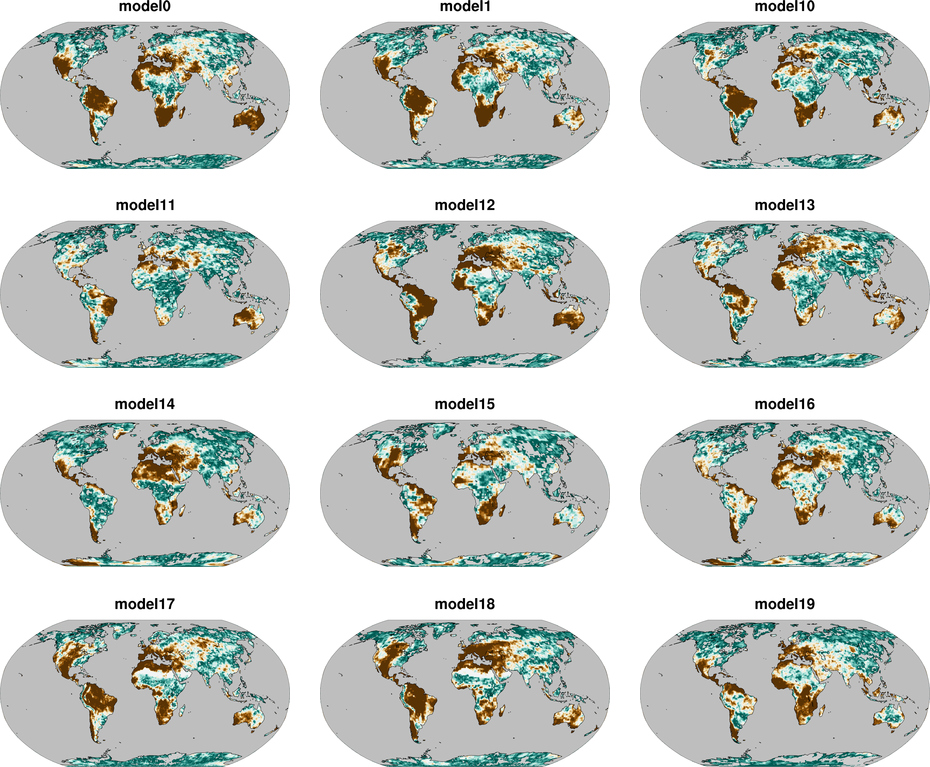

In [52]:
# -- Plot the individual models
wfuture = 'ssp585_farch'
iplot_members(ens_diff[wfuture], N=1, **pp)

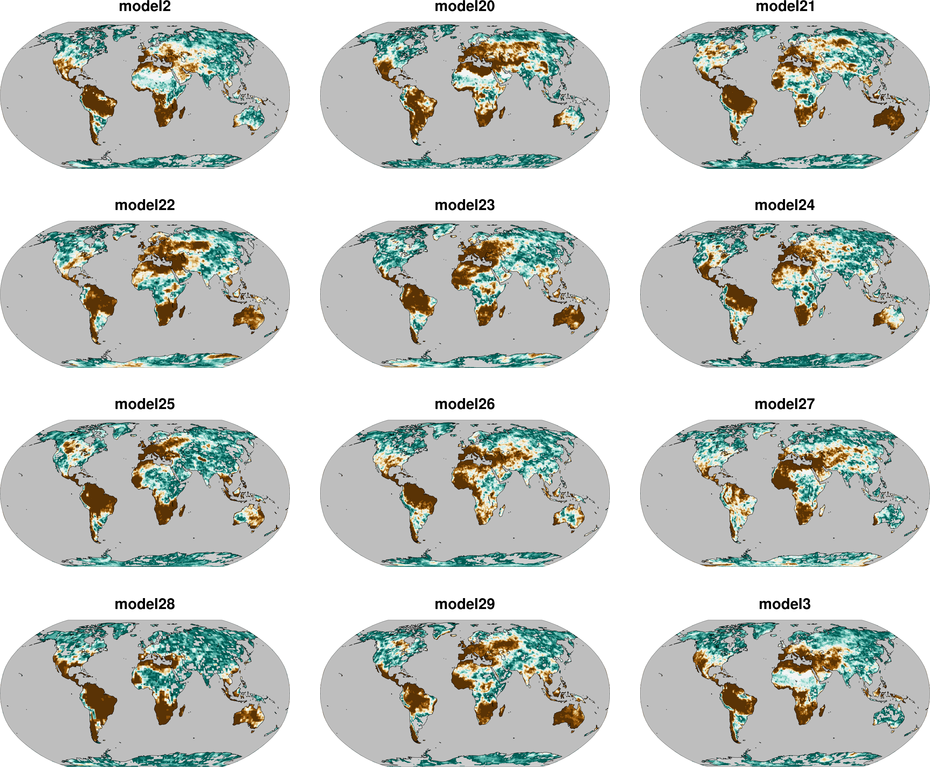

In [53]:
iplot_members(ens_diff[wfuture], N=2, **pp)

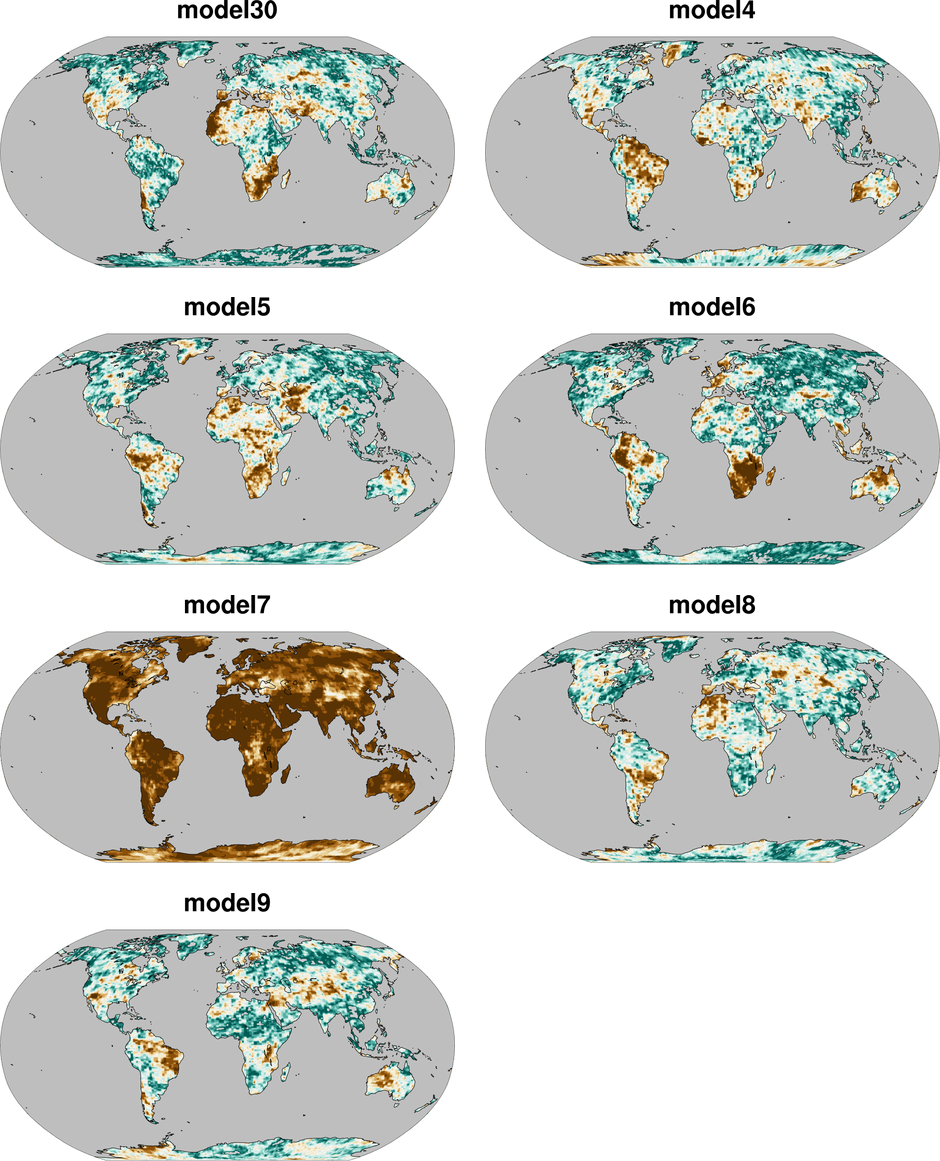

In [59]:
iplot_members(ens_diff[wfuture], N=3, **pp)

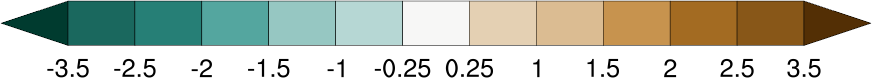

In [9]:
# -- Colorbar
def extract_labelbar(figure_file,labelbar_file) :
    #import PIL
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((55, 564, 930, 642))
    im_crop.save(labelbar_file, quality=95)

# -- Base plot for the colorbar
wfuture = 'ssp585_farch'
plot_4colorbar = plot_ipcc(ens_diff[wfuture][ens_diff[wfuture].keys()[0]],
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.015|lbBoxEndCapStyle=TriangleBothEnds',
                      **pp_colorbar)

# -- color bar file
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'+variable+'_colorbar.png'

# -- Extract the colorbar
extract_labelbar(cfile(plot_4colorbar),colorbar_file)

Image(colorbar_file)

## PDF

In [10]:
plot_4colorbar = plot_ipcc(ens_diff[wfuture][ens_diff[wfuture].keys()[0]],
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.015|lbBoxEndCapStyle=TriangleBothEnds',
                           format='pdf',
                      **pp_colorbar)

# -- color bar file
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'+variable+'_colorbar.pdf'
cfile(cpdfcrop(plot_4colorbar), target=colorbar_file)

'/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/DF6_colorbar.pdf'

## Ensemble statistics

In [8]:
perc_agreement = '80'
outdatadir = '/home/jservon/Chapter12_IPCC/data/Figure_12.4/DF6/'

signif90_dict = dict()
for exp in exp_list:
    # -- Experiment and period
    experiment = exp['experiment']
    period = exp['clim_period']
    wfuture = experiment+'_'+period

    # -- Mask of models with
    ens_mask_pos = ccdo(ens_diff[wfuture], operator='gtc,0')
    ens_mask_neg = ccdo(ens_diff[wfuture], operator='ltc,0')
    ens_mask_zero = ccdo(ens_diff[wfuture], operator='eqc,0')

    perc_ens_pos = fmul( fdiv( ccdo_ens(ens_mask_pos, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_neg = fmul( fdiv( ccdo_ens(ens_mask_neg, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_zero = fmul( fdiv( ccdo_ens(ens_mask_zero, operator='enssum'), len(ens_diff[wfuture]) ), 100 )

    # -- Signif90
    signif90_pos = ccdo(perc_ens_pos, operator='gtc,'+perc_agreement)
    signif90_neg = ccdo(perc_ens_neg, operator='gtc,'+perc_agreement)
    signif90_zero = ccdo(perc_ens_zero, operator='gtc,'+perc_agreement)
    signif90_dict[wfuture] = fmul( fadd( fadd(signif90_pos, signif90_neg), signif90_zero), -1)
    if wfuture=='ssp126_farch':
        panel = 'panel_g'
    if wfuture=='ssp585_midch':
        panel = 'panel_h'
    if wfuture=='ssp585_farch':
        panel = 'panel_i'
    mask_agreement_name = outdatadir + 'mask_'+perc_agreement+'perc-agreement_DF6_'+panel+'_'+wfuture+'_minus_baseline.nc'
    cfile(signif90_dict[wfuture], target=mask_agreement_name)
    cmd = 'ncatted -O -a comment,global,o,c,"This file is used for the hatching of '+panel+' of figure 12.4 - Chapter 12" '+mask_agreement_name
    os.system(cmd)


outdir = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'

pp['tiMainFontHeightF'] = 0.032
pp['gsnStringFontHeightF'] = 0.03

wfuture = 'ssp585_midch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_h_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel h of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p1 = plot_ipcc(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
          title = '2041-2060, SSP5-8.5',
          gsnCenterString = 'Change in # droughts',
          **pp
         )
cfile(p1, target = outdir + 'panel_h_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

wfuture = 'ssp585_farch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_i_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel i of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p2 = plot_ipcc(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
          title = '2081-2100, SSP5-8.5',
          gsnCenterString = 'Change in # droughts',
          **pp
         )
cfile(p2, target = outdir + 'panel_i_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

wfuture = 'ssp126_farch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_g_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel g of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p3 = plot_ipcc(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0|gsnAddCyclic=True',
          title = '2081-2100, SSP1-2.6',
          gsnCenterString = 'Change in # droughts',
          **pp
         )
cfile(p3, target = outdir + 'panel_g_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

mp = cpage(fig_lines=[[p1,p2,p3]],
            insert=colorbar_file,
            insert_width=400, page_width=1200
          )

'/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/panel_g_DF6_ssp126_farch_80perc-agreement.png'

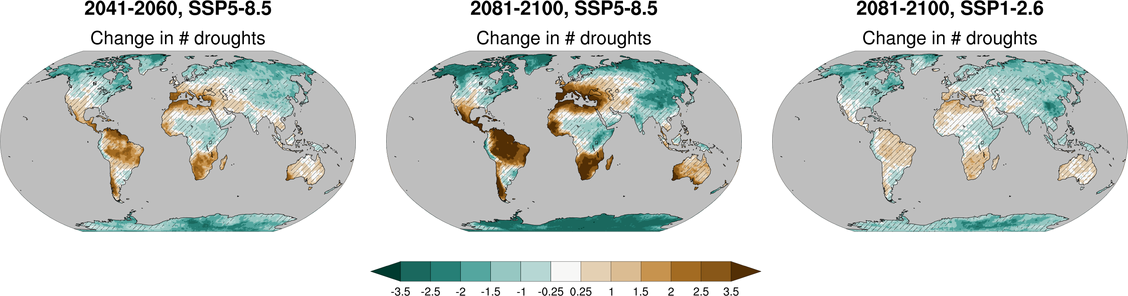

In [10]:
iplot(mp)

## Pdf version

In [9]:
wfuture = 'ssp585_midch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_h_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel h of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p1 = plot_ipcc(ensmedian_field,
                signif90_dict[wfuture],
                shade_above = -0.99999,
                shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                title = '2041-2060, SSP5-8.5',
                gsnCenterString = 'Change in # droughts',
                format='pdf',
                **pp
                )
cfile(cpdfcrop(p1), target = outdir + 'panel_h_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')

wfuture = 'ssp585_farch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_i_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel i of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p2 = plot_ipcc(ensmedian_field,
                signif90_dict[wfuture],
                shade_above = -0.99999,
                shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
                title = '2081-2100, SSP5-8.5',
                gsnCenterString = 'Change in # droughts',
                format='pdf',
                **pp
                )
cfile(cpdfcrop(p2), target = outdir + 'panel_i_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')

wfuture = 'ssp126_farch'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_filename = outdatadir + 'DF6_panel_g_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel g of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p3 = plot_ipcc(ensmedian_field,
                signif90_dict[wfuture],
                shade_above = -0.99999,
                shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0|gsnAddCyclic=True',
                title = '2081-2100, SSP1-2.6',
                gsnCenterString = 'Change in # droughts',
                format='pdf',
                **pp
                )
cfile(cpdfcrop(p3), target = outdir + 'panel_g_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')


'/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/panel_g_DF6_ssp126_farch_80perc-agreement.pdf'

#  